In [1]:
%matplotlib inline

import osmnx as ox
import numpy as np
# from hmmlearn.hmm import MultinomialHMM
import matplotlib.pyplot as plt

# from math import cos, sin, asin, sqrt, radians

import geopandas as gpd
from shapely.geometry import Point, LineString

import networkx as nx
import geopandas as gpd

# LOAD DATA

In [2]:
import pandas as pd
# lon | lat,
# ...
fname='preprocess025.csv'
path='data/'
df = pd.read_csv(f'{path}{fname}')
df = df.loc[:,['vehicle','x','y','datetime','trip','heading']]
df.head()

,vehicle,x,y,datetime,trip,heading
0,36A26255,106.669520,10.772121,4/27/2018 9:22,0,150.921623
1,36A26255,106.669930,10.771392,4/27/2018 9:22,0,161.372021
2,36A26255,106.669975,10.771260,4/27/2018 9:22,0,164.387732
3,36A26255,106.670170,10.770570,4/27/2018 9:22,0,153.277055
4,36A26255,106.670420,10.770079,4/27/2018 9:23,0,153.277055


## Get osm graph: vbd

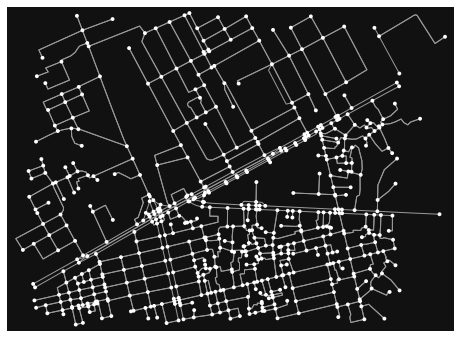

In [3]:
min_x = df['x'].min()
max_x = df['x'].max()

min_y = df['y'].min()
max_y = df['y'].max()
west, south, east, north = max_x, min_y, min_x, max_y
G1 = ox.graph_from_bbox(north, south, east, west,network_type='all', truncate_by_edge=True, retain_all=True)
fig, ax = ox.plot_graph(G1)


In [4]:
def graph_to_gdf(G):  
    rows = []
    for node_from, node_to, edge in G.edges(data=True):
        if "geometry" in edge.keys():
            geometry = edge["geometry"]
        else:
            f = G.nodes[node_from]
            t = G.nodes[node_to]
            geometry = LineString([[f["x"], f["y"]], [t["x"], t["y"]]])
        base = {
            "from": node_from,
            "to": node_to,
            "id": edge["osmid"],
            "length": edge["length"],  # meters
            "geometry": geometry,
        }
        rows.append(base)
    gdf = gpd.GeoDataFrame(rows)
    return gdf
gdf = graph_to_gdf(G1)
gdf.head()

,from,to,id,length,geometry
0,366372448,5057828486,32586227,30.882,"LINESTRING (106.67178 10.76668, 106.67169 10.7..."
1,366372448,5057828564,32586227,38.903,"LINESTRING (106.67178 10.76668, 106.67184 10.7..."
2,366372448,5057828560,468380366,28.809,"LINESTRING (106.67178 10.76668, 106.67176 10.7..."
3,366372448,5057828543,468380366,40.051,"LINESTRING (106.67178 10.76668, 106.67180 10.7..."
4,366374108,5057828212,32586228,19.541,"LINESTRING (106.66511 10.76511, 106.66528 10.7..."


# HMM COMPONENTS

In [5]:
import math
from haversine import haversine, Unit # (lat, lon) # print(tuple(Unit))

In [201]:
def get_proj_point(z1, line):
    '''
    z1: Point(x,y)
    line: LineString()
    return:
        z1's projected point.
        ???? type: (lat, lon) ???
    '''
    return line.interpolate(line.project(z1))
 
def great_circle_distance(z1, z2):
    '''
    Calculate distance between 2 GPS points

    params:
        z1, z2: Point(x,y) \n
    return:
        distance(z1, z2)
        unit: meters
    '''
    # lat, lon
    p1 = (z1.y, z1.x)
    p2 = (z2.y, z2.x)

    # using haversine formula
    return haversine(p1, p2, unit=Unit.METERS)

# def route_to_linestring(G, route):
#     '''
#     Convert list of node IDs to LineString

#     params:
#         G: osmnx graph
#         route: list of node IDs
#     return:
#         route as LineString
#     '''
#     nodes, edges = ox.graph_to_gdfs(G)
#     route_nodes = nodes.loc[route]
#     route_line = LineString(route_nodes['geometry'].tolist())
#     return route_line

def route_distance(G, x1, x2):
    '''
    Calculate shortest path length between 2 projected points in graph G  
    x1, x2: (lat, lon) <-> (y, x) \n
    return:
        shortest path length between p1 and p2
        unit: meters
    '''
    x1_nearest_node = ox.nearest_nodes(G,x1.x, x1.y)
    x2_nearest_node = ox.nearest_nodes(G,x2.x, x2.y)
    shortest_path = ox.shortest_path(G, x1_nearest_node, x2_nearest_node)
    
    # calculate route length
    route_number = len(shortest_path)
    nodes, edges = ox.graph_to_gdfs(G1) #  !!!speed this up!!!

    shortest_path_len = 0
    for idx, id in enumerate(shortest_path):
        if idx==route_number-1:
            break
        node1 = nodes.loc[shortest_path[idx]]
        node2 = nodes.loc[shortest_path[idx+1]]
        # convert to Point()
        node1 = Point(node1.x, node1.y)
        node2 = Point(node2.x, node2.y)
        shortest_path_len = shortest_path_len + great_circle_distance(node1, node2)
    
    return shortest_path_len

def emision_prob_matrix(Z, R, round_digit=5):
    '''
    compute all Emission probability p( z_t | r_i ) \n
    input:
        measured points: Z
        road segments: R
    output:
        emission matrix: ||Z|| layer, layer Z_i has ||R_i|| nodes 
    '''
    emision_matrix = []
    for i in range(len(Z)):
        # estimate sigma_z
        median_t = 0
        for j in range(len(R[i])):
            point_measured = Z[i]
            point_proj = get_proj_point(point_measured, R[i][j])
            median_t = median_t + great_circle_distance(point_measured, point_proj)
        median_t = median_t / len(R[i])
        
        sigma_z = 1.4826 * median_t
        # calculate emission prob
        point_measured = Z[i]
        emission_zt = []
        for j in range(len(R[i])):
            point_proj = get_proj_point(point_measured, R[i][j])

            # EMISSION FORMULA
            p_zt_ri = 1 / ( math.sqrt(2 * math.pi) * sigma_z)
            p_zt_ri = p_zt_ri * math.exp(-0.5 * (great_circle_distance(point_measured, point_proj) / sigma_z)**2)
            p_zt_ri = round(p_zt_ri, round_digit)
            emission_zt.append(p_zt_ri)
        # append emission layer
        emision_matrix.append(emission_zt)
    return emision_matrix

def transition_prob_matrix(G, Z, R, round_digit=5):
    '''
    '''
    len_z = len(Z)
    transition_zt = []
    for i in range(len_z):
        if i==len_z-1:
            break
        # ..
        layer_pre = R[i]
        layer_next = R[i+1]
        point_measured = Z[i]
        point_transition = Z[i+1]
        # estimate beta
        median_t = 0
        for idx_row, road_pre in enumerate(layer_pre):
        
            for idx_col, road_next in enumerate(layer_next):
                point_proj_measured = get_proj_point(point_measured, road_pre)
                point_proj_trans = get_proj_point(point_transition, road_next)
                # calculate dt
                dt = great_circle_distance(point_measured, point_transition)
                dt = abs( dt-route_distance(G, point_proj_measured, point_proj_trans))
                median_t = median_t + dt
        beta = np.log(2) * median_t / (len(layer_pre) + len(layer_next))
        # calculate transition prob
        prob_ri_ri1 = np.zeros((len(layer_pre), len(layer_next)))
        for idx_row, road_pre in enumerate(layer_pre):
            for idx_col, road_next in enumerate(layer_next):
                point_proj_measured = get_proj_point(point_measured, road_pre)
                point_proj_trans = get_proj_point(point_transition, road_next)
                # calculate dt
                dt = great_circle_distance(point_measured, point_transition)
                dt = abs( dt-route_distance(G, point_proj_measured, point_proj_trans))
                # calculate probability (Exponential probability distribution )
                p_ri_ri1 = 1 / beta * math.exp(-dt / beta)
                prob_ri_ri1[idx_row][idx_col] = p_ri_ri1
        transition_zt.append(prob_ri_ri1)
    return transition_zt



In [198]:
def viterbi_algorithm(trace, emission_matrix, transition_matrix):
    layer_number = len(trace)

    viterbi_matrix = []
    for layer_idx in range(len(trace)):
        # init prob
        if layer_idx==0:
            viterbi_matrix.append(emission_matrix[0])
            continue
        # choose max prob for every node in the next layer
        prob_pre = viterbi_matrix[layer_idx-1]
        prob_next = []
        
        for idx in range(len(emission_matrix[layer_idx])):
            max_val = 0
            emiss_matrix = emission_matrix[layer_idx]
            trans_matrix = transition_matrix[layer_idx-1]
            for pre_idx in range(len(prob_pre)):
                prob = emiss_matrix[idx]*trans_matrix[pre_idx][idx]
                prob = prob*prob_pre[pre_idx]
                # choose max probability for every node
                if prob > max_val:
                    max_val = prob
            prob_next.append(max_val)
        viterbi_matrix.append(prob_next)
    
    # get selected nodes
    selected_nodes = []
    for layer_idx in range(len(viterbi_matrix)):
        max_node = max(viterbi_matrix[layer_idx])
        list_node = [idx for idx, val in enumerate(viterbi_matrix[layer_idx]) if val==max_node]
        selected_nodes.append(list_node[0])

    return selected_nodes

def extract_matching_path(selected_nodes, trace, road_segments):
    lines = []
    for i, roads in enumerate(road_segments):
        road_idx = selected_nodes[i]
        lines.append( roads[road_idx] )
    
    # get projected point
    trace_matching = []
    for idx, line in enumerate(lines):
        point_proj = get_proj_point(trace[idx], line)
        trace_matching.append(point_proj)

    return trace_matching

# APPLY HMM & VITERBI ALGORITHM


In [199]:
def get_list_trace(df):
    '''
    Convert from dataframe to list traces

    input:
        dataframe has [x,y,trip] columns
    output:
        list traces
    '''
    df['result'] = df.set_index('trip').values.tolist()
    df = df.groupby('trip')['result'].apply(list)
    list_trace = df.values
    return list_trace

def get_neighbor_edges(gdf, z1, t=15):
    near_edges = []
    for gdf_ix, row in gdf.iterrows():
        l = row["geometry"]
        p2 = l.interpolate(l.project(z1))
        d = great_circle_distance(z1, p2)
        if d < t:
            # near_edges.append({
            #     "id": gdf_ix,
            #     "distance": d,
            #     "from_node": row["from"],
            #     "to_node": row["to"],
            # })
            near_edges.append(gdf_ix)
    return near_edges

In [202]:
gdf = graph_to_gdf(G1)
list_trace = get_list_trace(df[['x','y','trip']].copy())

ls_x = []
ls_y = []
trips = []
counter = 0

# test 
trace = []
trace_matching = []

for idx, trace in enumerate(list_trace):
    idx = 0
    trace = [Point(p[0],p[1]) for p in trace]
    # Find all road segments nearby every single point 
    road_segment_ids = []
    for p in trace:
        near_edges = get_neighbor_edges(gdf, p)
        # print(p, near_edges)
        road_segment_ids.append(near_edges)
    road_segments = [gdf.loc[ids]['geometry'].values for ids in road_segment_ids]
    # hmm
    emission_matrix = emision_prob_matrix(trace, road_segments)
    transition_matrix = transition_prob_matrix(G1, trace, road_segments)
    selected_nodes = viterbi_algorithm(trace, emission_matrix, transition_matrix)
    trace_matching = extract_matching_path(selected_nodes, trace, road_segments)
    print(len(trace), len(trace_matching))
    print(emission_matrix)
    print(transition_matrix)
    # dataframe
    ls_x = [p.x for p in trace]
    ls_y = [p.y for p in trace]
    trips = [counter]*len(ls_x)
    counter = counter + 1
    break

# # build df_proj
# dict = {'x': ls_x, 'y': ls_y, 'trip': trips}
# df_proj = pd.DataFrame(dict)
# df_proj


5 5
[[0.02975, 0.02975], [0.02772, 0.034, 0.034, 0.02637, 0.02637, 0.02772, 0.02637, 0.02637, 0.02637], [0.01789, 0.01904, 0.01904, 0.02315, 0.01798, 0.01789, 0.01789, 0.02315, 0.01789], [0.02122, 0.02861, 0.02122], [0.01859, 0.01859, 0.01592, 0.01838, 0.01592, 0.01838]]
[array([[0.0218348, 0.0218348, 0.0218348, 0.0218348, 0.0218348, 0.0218348,
        0.0218348, 0.0218348, 0.0218348],
       [0.0218348, 0.0218348, 0.0218348, 0.0218348, 0.0218348, 0.0218348,
        0.0218348, 0.0218348, 0.0218348]]), array([[0.01503089, 0.01503089, 0.01503089, 0.01503089, 0.01503089,
        0.01503089, 0.01503089, 0.01503089, 0.01503089],
       [0.01503089, 0.01503089, 0.01503089, 0.01503089, 0.01503089,
        0.01503089, 0.01503089, 0.01503089, 0.01503089],
       [0.01503089, 0.01503089, 0.01503089, 0.01503089, 0.01503089,
        0.01503089, 0.01503089, 0.01503089, 0.01503089],
       [0.01503089, 0.01503089, 0.01503089, 0.01503089, 0.01503089,
        0.01503089, 0.01503089, 0.01503089, 0.0150

<AxesSubplot:>

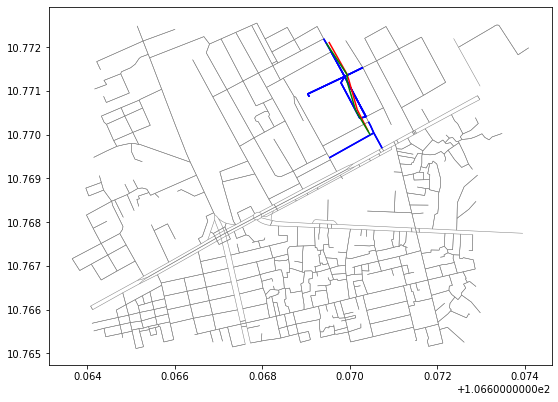

In [204]:
# plot the base map in grey
ax = gdf.plot(figsize=(9,9), lw=0.5, color="grey")

# raw trace in red
for i in range(len(road_segments)):
    for j in range(len(road_segments[i])):
        gpd.GeoSeries([ road_segments[i][j] ]).plot(ax=ax, color="blue")
gpd.GeoSeries([ LineString(trace) ]).plot(ax=ax, color="red")
gpd.GeoSeries([ LineString(trace_matching) ]).plot(ax=ax, color="green")
